# 03 — Feature Engineering

Purpose: create derived features to support segmentation and modeling. This notebook:

- Loads cleaned data from `data/processed/BMW_Worldwide_Sales_Cleaned.csv`
- Generates price categories, vehicle age, market segments and boolean features (e.g., `Green_Vehicle`)
- Exports feature dataset to `data/processed/BMW_Worldwide_Sales_Features.csv`

Run instructions: run after `01_data_cleaning.ipynb` and `02_eda.ipynb`. Focus on the exported features for model inputs.

# BMW Sales Data Feature Engineering

This notebook performs comprehensive feature engineering on BMW worldwide sales data to:
1. Create market segmentation features
2. Analyze sales patterns and distributions
3. Calculate market share metrics
4. Identify key performance indicators
5. Generate visualizations for analysis

In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Type stubs may not be available for sklearn, but imports work fine
from sklearn.preprocessing import LabelEncoder  # type: ignore
from sklearn.ensemble import RandomForestRegressor  # type: ignore

# Set up display options
sns.set(style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (10, 6)
pd.set_option('display.max_columns', None)

# Load the cleaned dataset
CLEAN_PATH = "../data/processed/BMW_Worldwide_Sales_Cleaned.csv"
df = pd.read_csv(CLEAN_PATH)

print("Data loaded successfully:", df.shape)
df.head()

Data loaded successfully: (50000, 11)


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


## 1. Data Preparation and Base Features

Initial data cleaning and basic feature creation:
- Model and region name standardization
- Geographic grouping (Region → Continent)
- Vehicle type classification
- Data validation and overview

In [11]:
# Ensure consistent capitalization and remove stray spaces
df["Model"] = df["Model"].astype(str).str.strip().str.title()
df["Region"] = df["Region"].astype(str).str.strip().str.title()

# Region to continent mapping
region_to_continent = {
    "Africa": "Africa",
    "Asia": "Asia",
    "Europe": "Europe",
    "Middle East": "Asia",
    "North America": "North America",
    "South America": "South America",
    "Oceania": "Oceania"
}

df["Continent"] = df["Region"].map(region_to_continent)
df["Continent"].fillna("Other", inplace=True)

# Vehicle type mapping
model_to_type = {
    "3 Series": "Sedan",
    "5 Series": "Sedan",
    "7 Series": "Sedan",
    "M3": "Performance",
    "M5": "Performance",
    "X1": "SUV",
    "X3": "SUV",
    "X5": "SUV",
    "X6": "SUV",
    "I3": "Electric",
    "I8": "Hybrid"
}

df["Vehicle_Type"] = df["Model"].map(model_to_type).fillna("Other")

print("Basic feature engineering complete. New columns added:")
print([col for col in df.columns if col not in ['Model', 'Year', 'Region', 'Color', 'Fuel_Type', 'Transmission', 'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume', 'Sales_Classification']])

Basic feature engineering complete. New columns added:
['Continent', 'Vehicle_Type']


## 2. Market Segmentation Features

Creating features for market analysis:
- Price categorization
- Market segment definition
- Vehicle age and condition metrics
- Engine power categories
- Environmental classification

In [12]:
# Price-related features
df['Price_Category'] = pd.qcut(df['Price_USD'], q=5, labels=['Budget', 'Entry', 'Mid', 'Premium', 'Luxury'])

# Handle division by zero in price per km calculation
df['Price_Per_KM'] = np.where(
    df['Mileage_KM'] > 0,
    df['Price_USD'] / df['Mileage_KM'],
    np.nan
)

# Market segments (with more detailed segmentation)
df['Market_Segment'] = df.apply(
    lambda x: 'Ultra-Luxury' if x['Model'] in ['7 Series']
    else 'Premium' if x['Model'] in ['5 Series', 'X5', 'X6']
    else 'Performance' if x['Model'] in ['M3', 'M5']
    else 'Entry', axis=1
)

# Vehicle age and condition
current_year = df['Year'].max()
df['Vehicle_Age'] = current_year - df['Year']
df['Age_Category'] = pd.cut(
    df['Vehicle_Age'],
    bins=[-np.inf, 0, 3, 6, np.inf],
    labels=['New', 'Recent', 'Mid-Age', 'Older']
)

# Engine and efficiency features
df['Engine_Power_Category'] = pd.cut(
    df['Engine_Size_L'], 
    bins=[0, 2.0, 3.0, 4.0, float('inf')],
    labels=['Economic', 'Mid-Power', 'High-Power', 'Ultra']
)

# Environmental features
df['Green_Vehicle'] = df['Fuel_Type'].isin(['Electric', 'Hybrid'])
df['Region_Green_Focus'] = df.apply(
    lambda x: 1 if x['Green_Vehicle'] and x['Continent'] in ['Europe', 'North America'] else 0, 
    axis=1
)

# Display new features with better formatting
print("\nSample of new market segmentation features:")
display(df[['Model', 'Market_Segment', 'Age_Category', 'Price_Category', 'Engine_Power_Category', 'Green_Vehicle']].head(10))

print("\nFeature value distributions:")
for col in ['Market_Segment', 'Age_Category', 'Price_Category', 'Engine_Power_Category']:
    print(f"\n{col} distribution:")
    print(df[col].value_counts(normalize=True).round(3) * 100)


Sample of new market segmentation features:


,Model,Market_Segment,Age_Category,Price_Category,Engine_Power_Category,Green_Vehicle
0,5 Series,Premium,Older,Premium,High-Power,False
1,I8,Entry,Older,Mid,Economic,True
2,5 Series,Premium,Recent,Luxury,Ultra,False
3,X3,Entry,New,Entry,Economic,False
4,7 Series,Ultra-Luxury,Mid-Age,Entry,Mid-Power,False
5,5 Series,Premium,Older,Budget,Economic,False
6,I8,Entry,Recent,Entry,Economic,False
7,M5,Performance,Older,Luxury,Economic,False
8,X3,Entry,Older,Luxury,Economic,False
9,I8,Entry,Mid-Age,Premium,Mid-Power,True



Feature value distributions:

Market_Segment distribution:
Market_Segment
Entry           45.8
Premium         27.1
Performance     17.8
Ultra-Luxury     9.3
Name: proportion, dtype: float64

Age_Category distribution:
Age_Category
Older      53.3
Recent     20.1
Mid-Age    19.8
New         6.9
Name: proportion, dtype: float64

Price_Category distribution:
Price_Category
Mid        20.0
Budget     20.0
Entry      20.0
Luxury     20.0
Premium    20.0
Name: proportion, dtype: float64

Engine_Power_Category distribution:
Engine_Power_Category
High-Power    28.6
Mid-Power     28.6
Ultra         27.0
Economic      15.7
Name: proportion, dtype: float64


## 3. Market Performance Metrics

Calculating key market performance indicators:
- Overall market share
- Segment-specific performance
- Regional market strength
- Sales volume analysis

In [13]:
# Group features for consistent analysis
base_features = ['Model', 'Region', 'Color', 'Fuel_Type', 'Transmission']
engineered_features = ['Vehicle_Type', 'Market_Segment', 'Price_Category', 'Engine_Power_Category']
numeric_features = ['Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Vehicle_Age']

# Market share calculations
df['Total_Year_Sales'] = df.groupby('Year')['Sales_Volume'].transform('sum')
df['Market_Share'] = (df['Sales_Volume'] / df['Total_Year_Sales']) * 100

# Segment performance by vehicle type and market segment
for segment_col in ['Vehicle_Type', 'Market_Segment']:
    df[f'{segment_col}_Sales'] = df.groupby(['Year', segment_col])['Sales_Volume'].transform('sum')
    df[f'{segment_col}_Share'] = (df['Sales_Volume'] / df[f'{segment_col}_Sales']) * 100

# Regional market strength with more granular analysis
df['Region_Year_Sales'] = df.groupby(['Year', 'Region'])['Sales_Volume'].transform('sum')
df['Regional_Share'] = (df['Sales_Volume'] / df['Region_Year_Sales']) * 100

# Comprehensive market analysis
print("Market analysis by vehicle type and segment:")
market_summary = pd.DataFrame()

# Vehicle Type analysis
vtype_summary = df.groupby('Vehicle_Type').agg({
    'Sales_Volume': 'sum',
    'Market_Share': 'mean',
    'Vehicle_Type_Share': 'mean',
    'Price_USD': ['mean', 'std']
}).round(2)
vtype_summary.columns = ['Total_Sales', 'Avg_Market_Share', 'Segment_Share', 'Avg_Price', 'Price_Std']
print("\nVehicle Type Performance:")
display(vtype_summary.sort_values('Total_Sales', ascending=False))

# Market Segment analysis
segment_summary = df.groupby('Market_Segment').agg({
    'Sales_Volume': 'sum',
    'Market_Share': 'mean',
    'Market_Segment_Share': 'mean',
    'Price_USD': ['mean', 'std']
}).round(2)
segment_summary.columns = ['Total_Sales', 'Avg_Market_Share', 'Segment_Share', 'Avg_Price', 'Price_Std']
print("\nMarket Segment Performance:")
display(segment_summary.sort_values('Total_Sales', ascending=False))

# Region analysis
region_summary = df.groupby('Region').agg({
    'Sales_Volume': 'sum',
    'Market_Share': 'mean',
    'Regional_Share': 'mean',
    'Green_Vehicle': 'mean'  # Showing environmental focus by region
}).round(2)
print("\nRegional Performance:")
display(region_summary.sort_values('Sales_Volume', ascending=False))

Market analysis by vehicle type and segment:

Vehicle Type Performance:


,Total_Sales,Avg_Market_Share,Segment_Share,Avg_Price,Price_Std
Vehicle_Type,,,,,
SUV,91523324,0.03,0.08,74857.56,26043.26
Sedan,70165288,0.03,0.11,75475.29,26084.48
Performance,45129382,0.03,0.17,74656.92,26033.40
Hybrid,23423891,0.03,0.33,75366.27,25627.70
Electric,23133849,0.03,0.32,74800.27,25851.24



Market Segment Performance:


,Total_Sales,Avg_Market_Share,Segment_Share,Avg_Price,Price_Std
Market_Segment,,,,,
Entry,115990632,0.03,0.07,75202.73,25952.68
Premium,68469254,0.03,0.11,74814.14,26097.80
Performance,45129382,0.03,0.17,74656.92,26033.40
Ultra-Luxury,23786466,0.03,0.32,75570.20,25856.58



Regional Performance:


,Sales_Volume,Market_Share,Regional_Share,Green_Vehicle
Region,,,,
Asia,42974277,0.03,0.18,0.51
Europe,42555138,0.03,0.18,0.51
North America,42402629,0.03,0.18,0.51
Middle East,42326620,0.03,0.18,0.50
Africa,41565252,0.03,0.18,0.50
South America,41551818,0.03,0.18,0.50


## 4. Time Series Analysis

Temporal analysis of sales data:
- Year-over-year growth calculation
- Rolling averages
- Growth distribution analysis
- Model performance trends

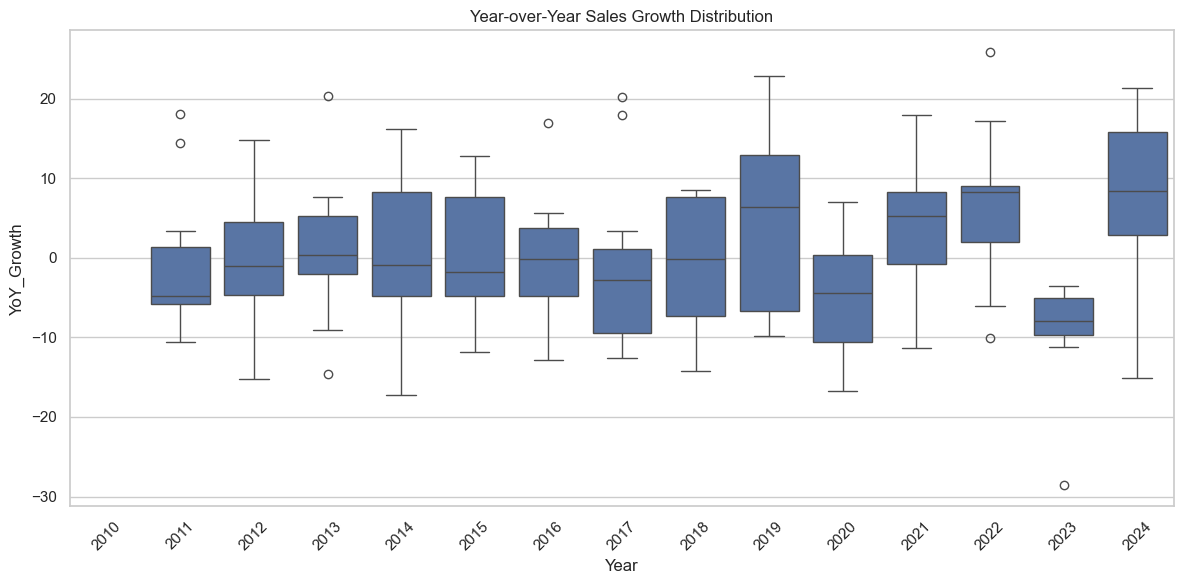


Top 5 models by average YoY growth:


Model
X6          2.053836
7 Series    1.888519
5 Series    1.463034
M5          0.884328
I3          0.830227
Name: YoY_Growth, dtype: float64

In [14]:
# Calculate year-over-year growth by model and vehicle type
yearly_sales = df.groupby(['Year', 'Model'])['Sales_Volume'].sum().reset_index()
yearly_sales['Last_Year_Sales'] = yearly_sales.groupby('Model')['Sales_Volume'].shift(1)
yearly_sales['YoY_Growth'] = (yearly_sales['Sales_Volume'] - yearly_sales['Last_Year_Sales']) / yearly_sales['Last_Year_Sales'] * 100

# Calculate rolling averages
yearly_sales['3Y_Avg_Sales'] = yearly_sales.groupby('Model')['Sales_Volume'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)

# Plot YoY growth trends
plt.figure(figsize=(12, 6))
sns.boxplot(data=yearly_sales, x='Year', y='YoY_Growth')
plt.title('Year-over-Year Sales Growth Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTop 5 models by average YoY growth:")
display(yearly_sales.groupby('Model')['YoY_Growth'].mean().sort_values(ascending=False).head())

## 5. Feature Importance Analysis

Statistical analysis of feature impact:
- Feature group importance
- Individual feature significance
- Correlation analysis
- Impact on sales performance

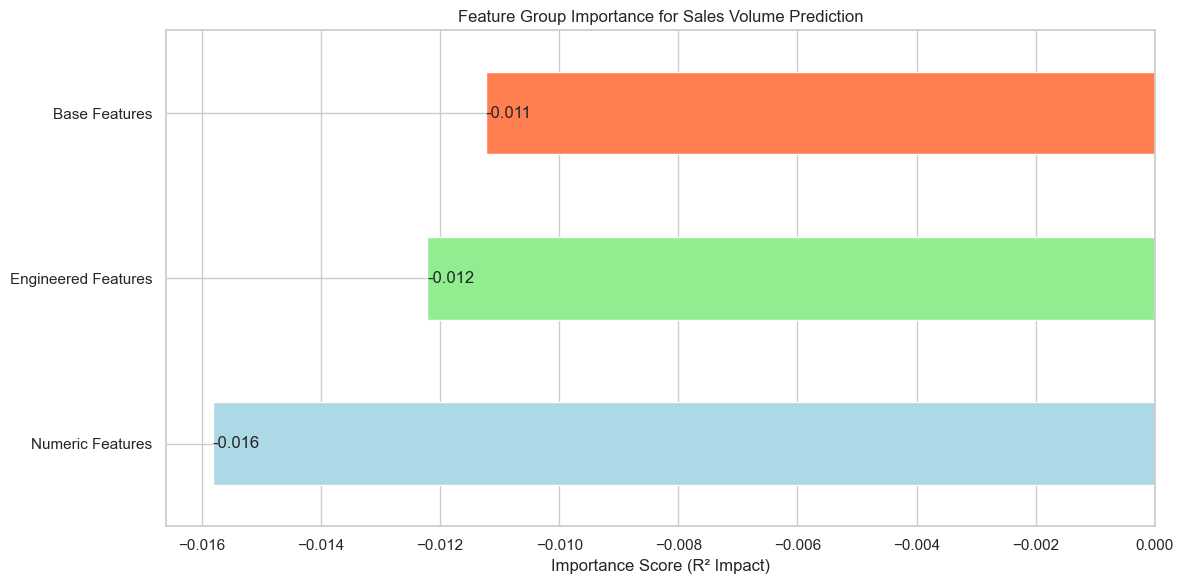

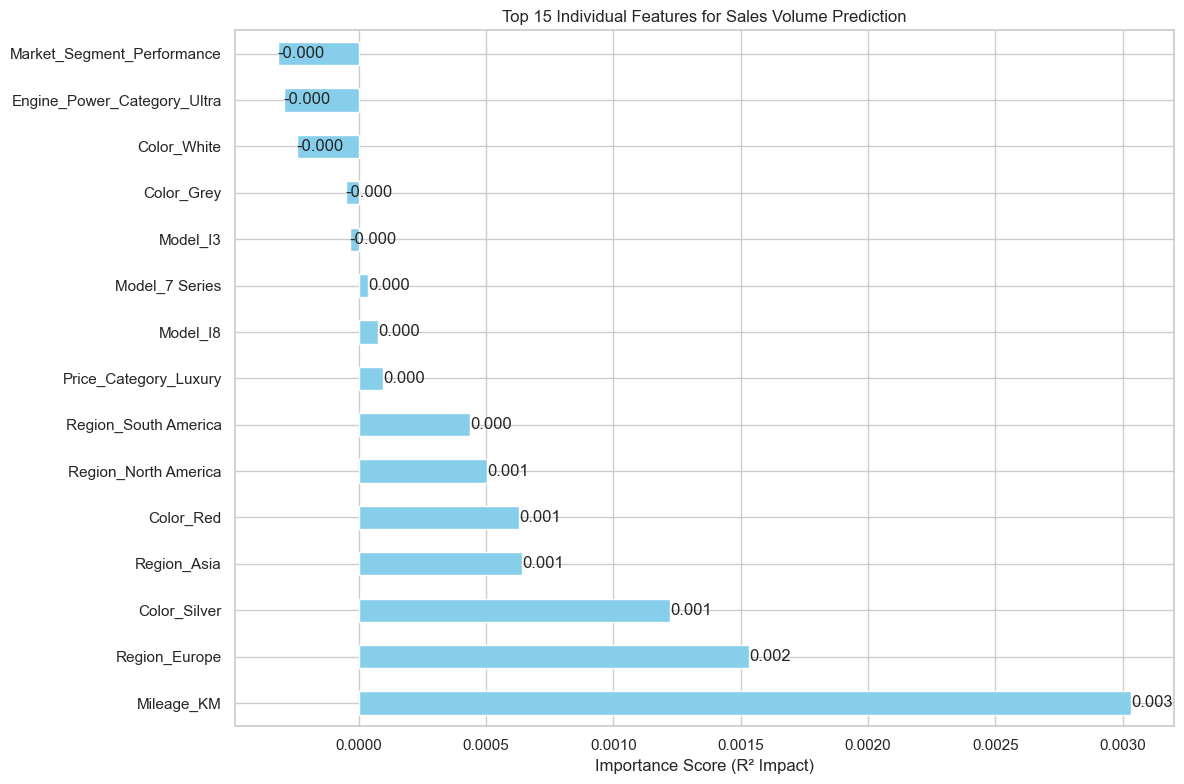


Top 15 most important individual features:
Mileage_KM                     0.0030
Region_Europe                  0.0015
Color_Silver                   0.0012
Region_Asia                    0.0006
Color_Red                      0.0006
Region_North America           0.0005
Region_South America           0.0004
Price_Category_Luxury          0.0001
Model_I8                       0.0001
Model_7 Series                 0.0000
Model_I3                      -0.0000
Color_Grey                    -0.0001
Color_White                   -0.0002
Engine_Power_Category_Ultra   -0.0003
Market_Segment_Performance    -0.0003
dtype: float64


In [21]:
# Prepare features for importance analysis
from sklearn.preprocessing import StandardScaler  # type: ignore
from sklearn.model_selection import train_test_split  # type: ignore
from sklearn.metrics import r2_score  # type: ignore
import numpy as np

# Define features to analyze
base_features = ['Model', 'Region', 'Color', 'Fuel_Type', 'Transmission']
engineered_features = ['Vehicle_Type', 'Market_Segment', 'Price_Category', 'Engine_Power_Category']
numeric_features = ['Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Vehicle_Age']

# Function to calculate feature importance using permutation
def calculate_feature_importance(X, y, feature_names):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale numeric features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    # Calculate base score
    base_score = r2_score(y_test, rf.predict(X_test_scaled))
    
    # Calculate importance by permutation
    importance_scores = []
    for i in range(X_test_scaled.shape[1]):
        X_test_permuted = X_test_scaled.copy()
        X_test_permuted[:, i] = np.random.permutation(X_test_permuted[:, i])
        permuted_score = r2_score(y_test, rf.predict(X_test_permuted))
        importance = base_score - permuted_score
        importance_scores.append(importance)
    
    return pd.Series(importance_scores, index=feature_names)

# Prepare data for both categorical and numeric features
X_categorical = pd.get_dummies(df[base_features + engineered_features], drop_first=True)
X_numeric = df[numeric_features].copy()

# Combine features
X_combined = pd.concat([X_categorical, X_numeric], axis=1)
y = df['Sales_Volume']

# Calculate feature importance
importance_scores = calculate_feature_importance(X_combined.values, y, X_combined.columns)

# Group importance by feature type
feature_groups = {
    'Base Features': [col for col in X_combined.columns if any(f in col for f in base_features)],
    'Engineered Features': [col for col in X_combined.columns if any(f in col for f in engineered_features)],
    'Numeric Features': numeric_features
}

grouped_importance = {}
for group, features in feature_groups.items():
    group_scores = importance_scores[features]
    grouped_importance[group] = group_scores.sum()

# Plot grouped importance
plt.figure(figsize=(12, 6))
group_df = pd.Series(grouped_importance).sort_values(ascending=True)
ax = group_df.plot(kind='barh', color=['lightblue', 'lightgreen', 'coral'])
plt.title('Feature Group Importance for Sales Volume Prediction')
plt.xlabel('Importance Score (R² Impact)')

# Add value labels
for i, v in enumerate(group_df.values):
    ax.text(v, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

# Plot top individual features
top_n = 15
top_features = importance_scores.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(12, 8))
ax = top_features.plot(kind='barh', color='skyblue')
plt.title(f'Top {top_n} Individual Features for Sales Volume Prediction')
plt.xlabel('Importance Score (R² Impact)')

# Add value labels
for i, v in enumerate(top_features.values):
    ax.text(v, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

print("\nTop 15 most important individual features:")
print(top_features.round(4))

## 6. Data Visualization

Comprehensive visualization of patterns:
- Market segment evolution
- Price-sales relationships
- Regional preferences
- Environmental trends

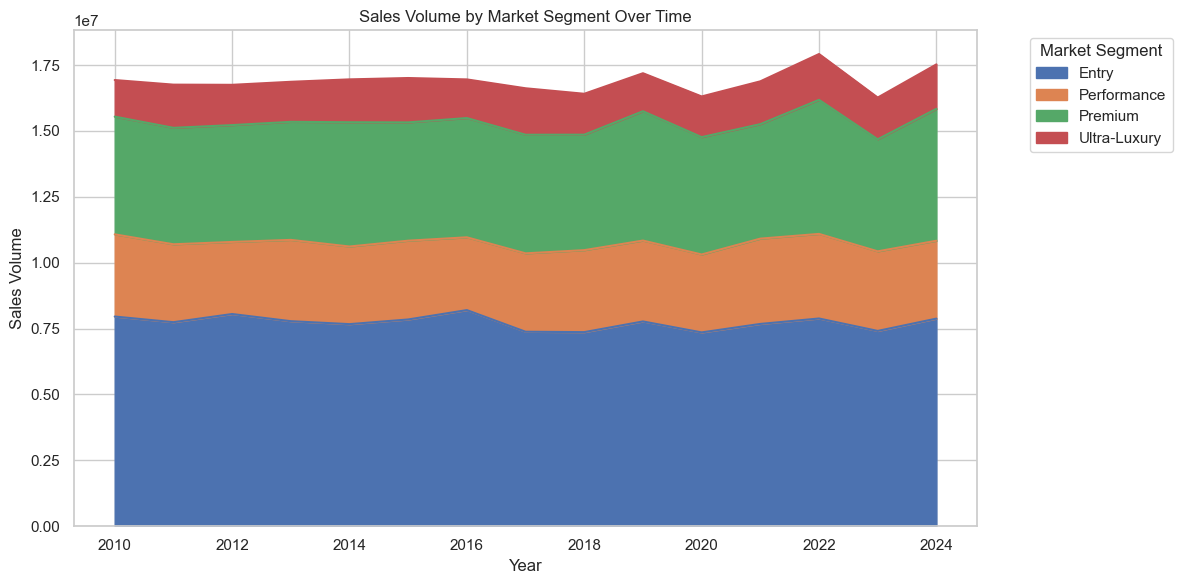

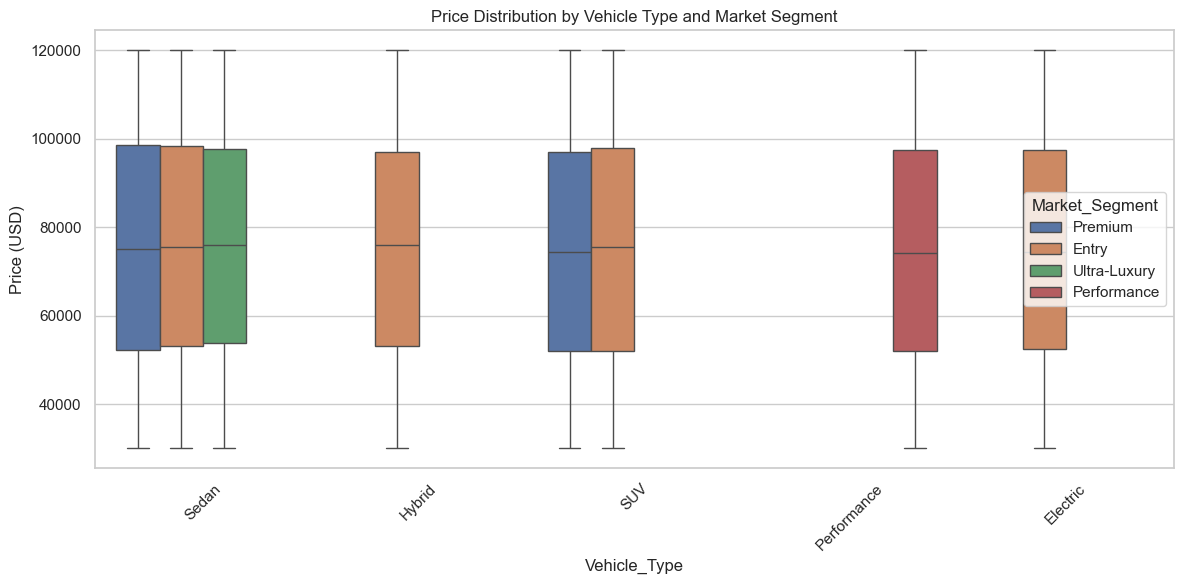

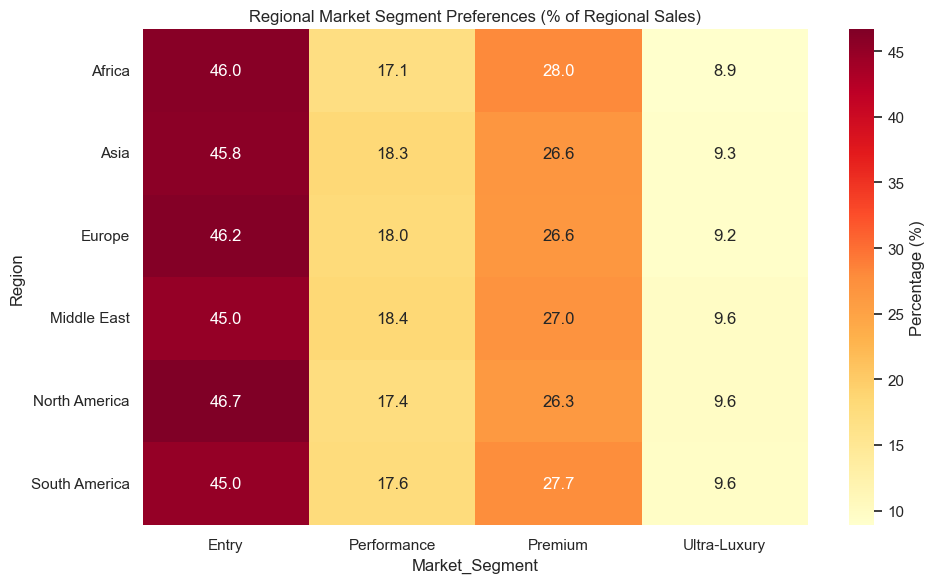

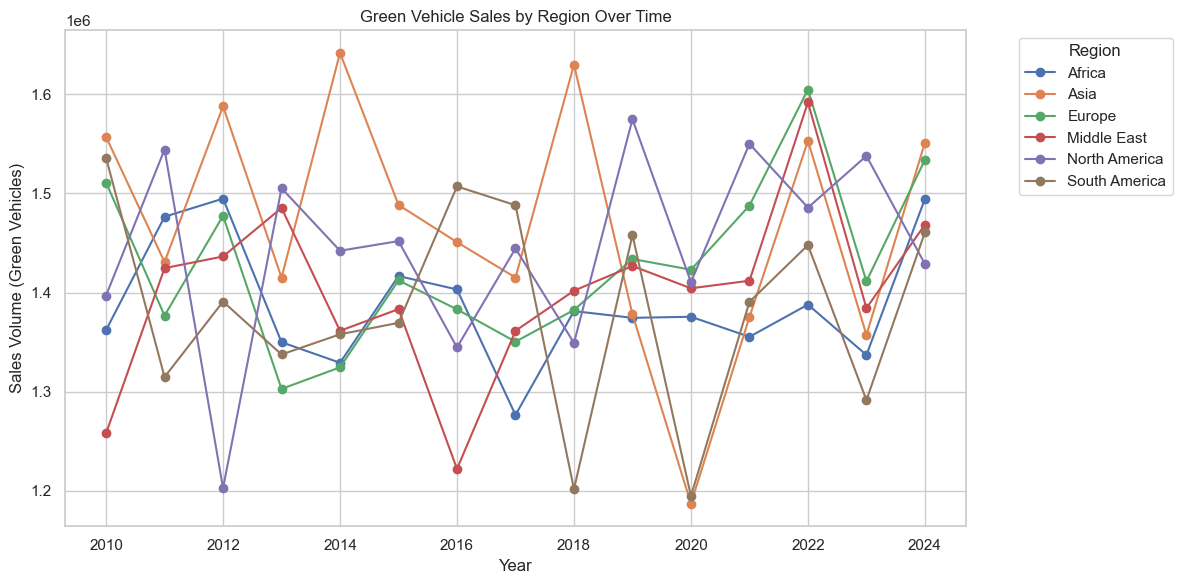

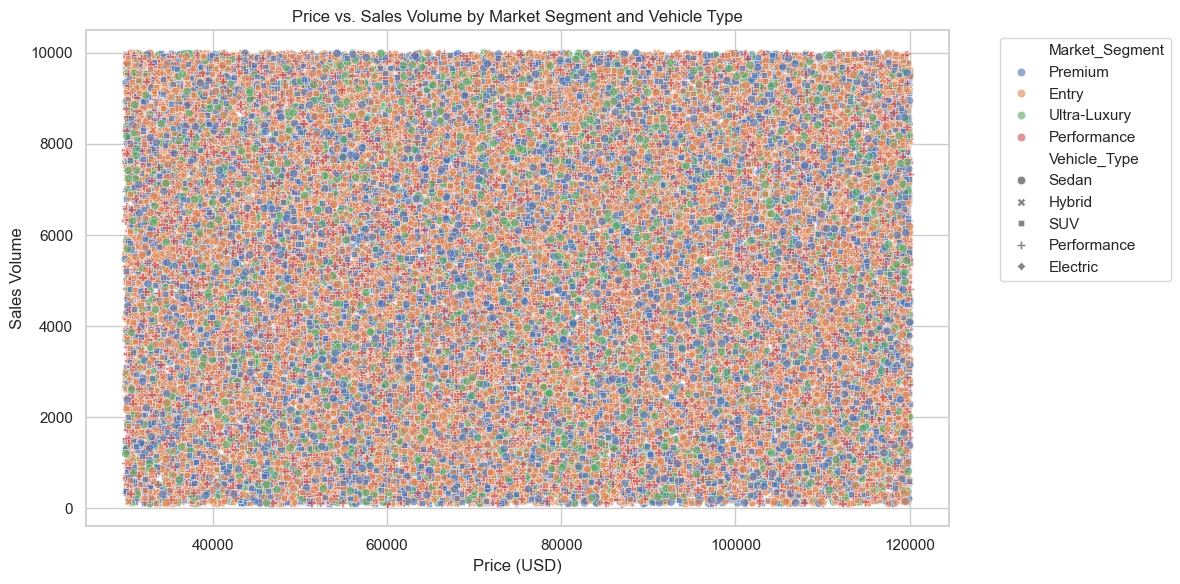

In [20]:
# Plot 1: Market segment trends
segment_trends = df.groupby(['Year', 'Market_Segment'])['Sales_Volume'].sum().unstack()
ax = segment_trends.plot(kind='area', stacked=True, figsize=(12, 6))
plt.title('Sales Volume by Market Segment Over Time')
plt.xlabel('Year')
plt.ylabel('Sales Volume')
plt.legend(title='Market Segment', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Plot 2: Price distribution by vehicle type
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Vehicle_Type', y='Price_USD', hue='Market_Segment')
plt.title('Price Distribution by Vehicle Type and Market Segment')
plt.xticks(rotation=45)
plt.ylabel('Price (USD)')
plt.tight_layout()
plt.show()

# Plot 3: Regional preferences heatmap (showing percentage distribution)
plt.figure(figsize=(10, 6))
regional_preferences = pd.pivot_table(
    data=df,
    values='Sales_Volume',
    index='Region',
    columns='Market_Segment',
    aggfunc='sum'
)
# Normalize to show percentage distribution within each region
regional_preferences_pct = regional_preferences.div(regional_preferences.sum(axis=1), axis=0) * 100
sns.heatmap(regional_preferences_pct, cmap='YlOrRd', annot=True, fmt='.1f', cbar_kws={'label': 'Percentage (%)'})
plt.title('Regional Market Segment Preferences (% of Regional Sales)')
plt.tight_layout()
plt.show()

# Plot 4: Environmental focus by region and year
env_trends = df[df['Green_Vehicle']].groupby(['Year', 'Region'])['Sales_Volume'].sum().unstack()
ax = env_trends.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Green Vehicle Sales by Region Over Time')
plt.xlabel('Year')
plt.ylabel('Sales Volume (Green Vehicles)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Plot 5: Price vs. Sales relationship with market segmentation
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df,
    x='Price_USD',
    y='Sales_Volume',
    hue='Market_Segment',
    style='Vehicle_Type',
    alpha=0.6
)
plt.title('Price vs. Sales Volume by Market Segment and Vehicle Type')
plt.xlabel('Price (USD)')
plt.ylabel('Sales Volume')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

## 7. Additional Analysis & Visualizations

Advanced analysis including correlation matrices, sales trends, and market insights.

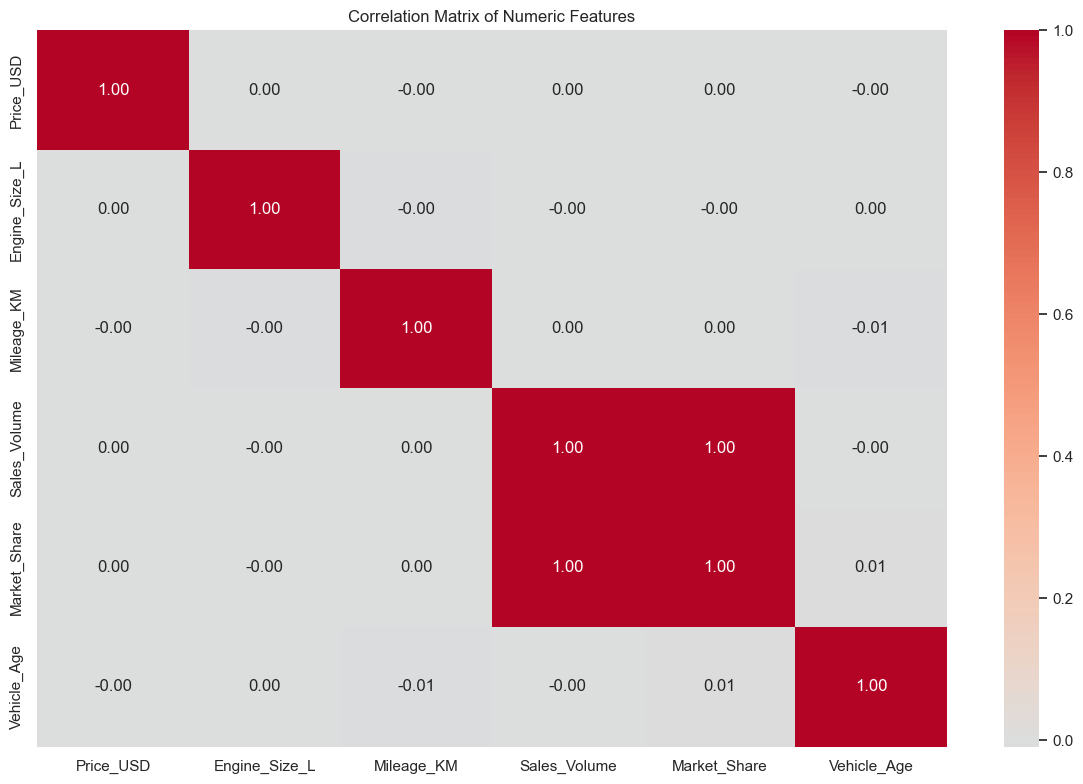

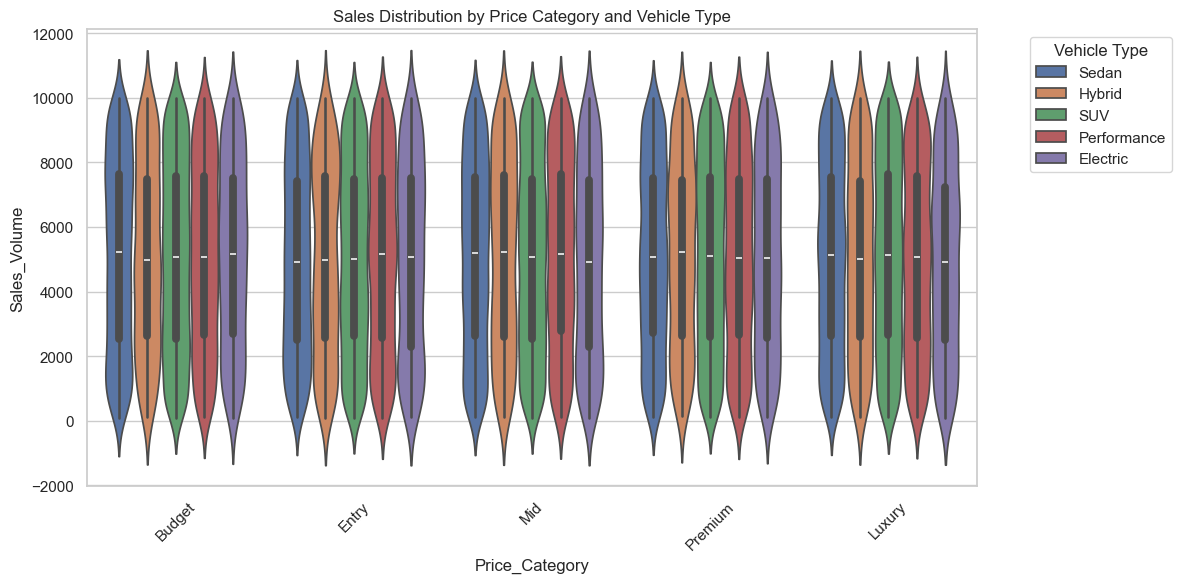

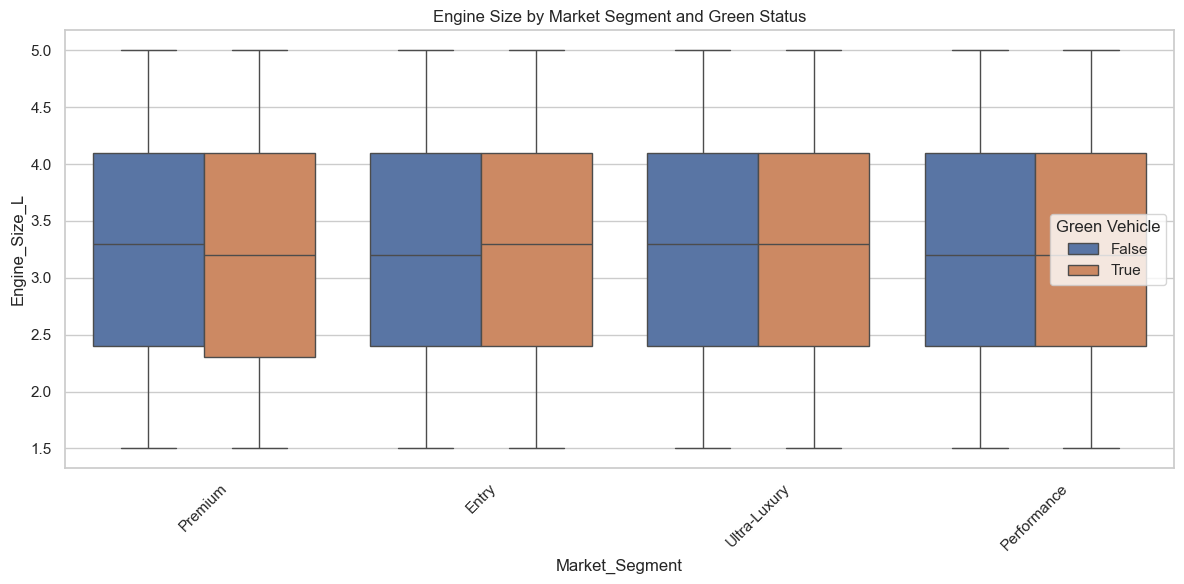

<Figure size 1200x600 with 0 Axes>

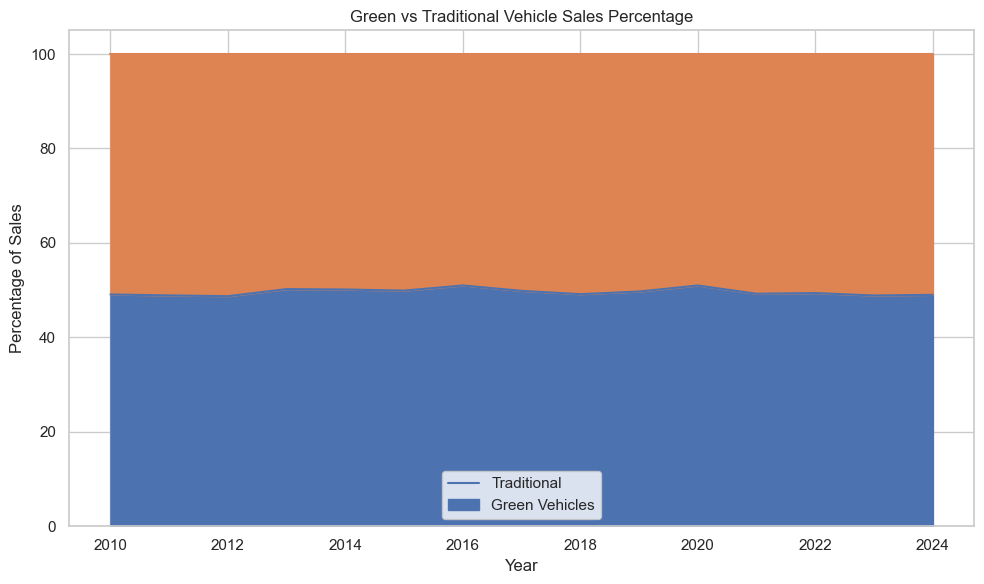

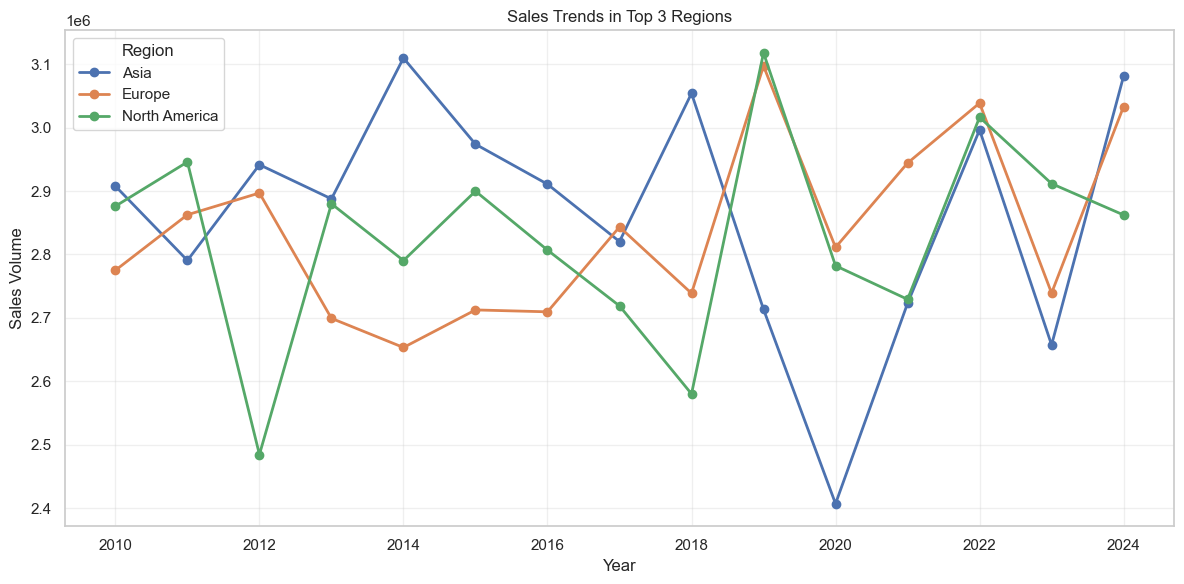

<Figure size 1500x600 with 0 Axes>

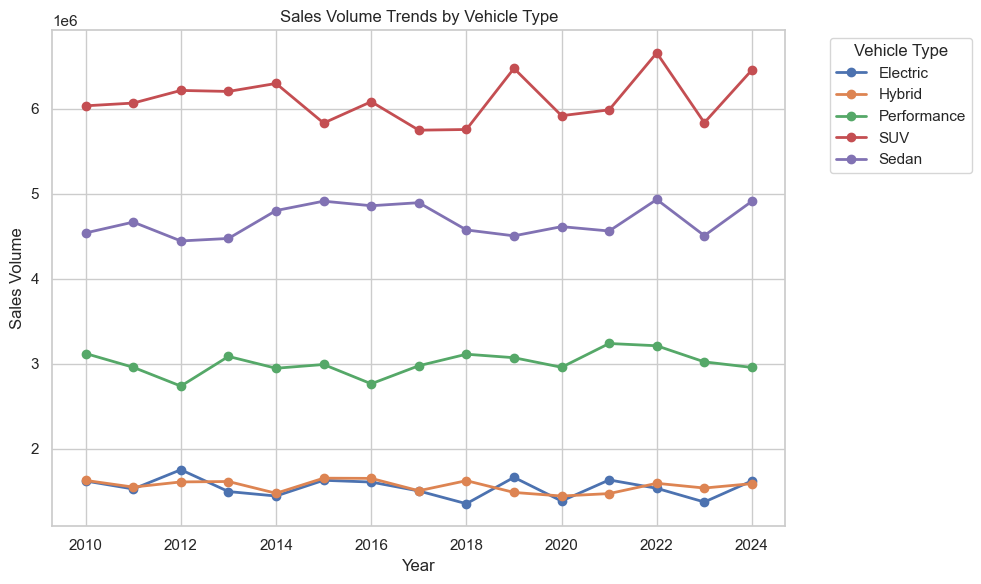


Key Performance Indicators:


,Metric,Value
0,Total Sales Volume,"253,375,734"
1,Average Price (USD),"$75,034.60"
2,Green Vehicle Percentage,50.4%
3,Premium Segment Share,27.1%
4,Top Selling Model,7 Series
5,Most Profitable Region,Asia


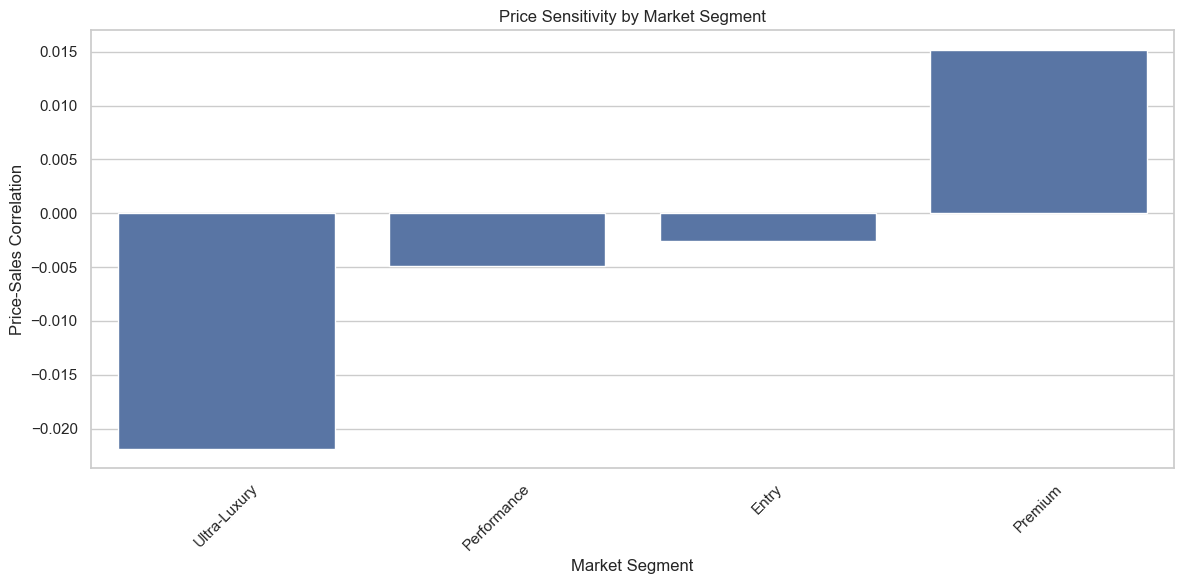


Insights from Price Sensitivity Analysis:
Ultra-Luxury: weak negative correlation (-0.02)
Performance: weak negative correlation (-0.00)
Entry: weak negative correlation (-0.00)
Premium: weak positive correlation (0.02)


In [22]:
# 1. Correlation Analysis
plt.figure(figsize=(12, 8))
numeric_cols = ['Price_USD', 'Engine_Size_L', 'Mileage_KM', 'Sales_Volume', 
                'Market_Share', 'Vehicle_Age']
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# 2a. Price Category vs Sales Volume by Vehicle Type
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='Price_Category', y='Sales_Volume', hue='Vehicle_Type')
plt.title('Sales Distribution by Price Category and Vehicle Type')
plt.xticks(rotation=45)
plt.legend(title='Vehicle Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# 2b. Engine Size Distribution by Market Segment
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Market_Segment', y='Engine_Size_L', hue='Green_Vehicle')
plt.title('Engine Size by Market Segment and Green Status')
plt.xticks(rotation=45)
plt.legend(title='Green Vehicle', loc='best')
plt.tight_layout()
plt.show()

# 2c. Green Vehicle Adoption Over Time
plt.figure(figsize=(12, 6))
yearly_green = df.groupby(['Year', 'Green_Vehicle'])['Sales_Volume'].sum().unstack()
yearly_green_pct = yearly_green.div(yearly_green.sum(axis=1), axis=0) * 100
yearly_green_pct.plot(kind='area', stacked=True)
plt.title('Green vs Traditional Vehicle Sales Percentage')
plt.ylabel('Percentage of Sales')
plt.xlabel('Year')
plt.legend(['Traditional', 'Green Vehicles'])
plt.tight_layout()
plt.show()

# 2d. Regional Market Evolution
plt.figure(figsize=(12, 6))
top_regions = df.groupby('Region')['Sales_Volume'].sum().nlargest(3).index
for region in top_regions:
    region_data = df[df['Region'] == region].groupby('Year')['Sales_Volume'].sum()
    plt.plot(region_data.index, region_data.values, marker='o', label=region, linewidth=2)
plt.title('Sales Trends in Top 3 Regions')
plt.xlabel('Year')
plt.ylabel('Sales Volume')
plt.legend(title='Region')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Sales Volume Trends by Vehicle Type
plt.figure(figsize=(15, 6))
yearly_vehicle_sales = df.groupby(['Year', 'Vehicle_Type'])['Sales_Volume'].sum().unstack()
yearly_vehicle_sales.plot(marker='o', linewidth=2)
plt.title('Sales Volume Trends by Vehicle Type')
plt.xlabel('Year')
plt.ylabel('Sales Volume')
plt.legend(title='Vehicle Type', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Key Performance Indicators (KPIs)
kpi_summary = pd.DataFrame({
    'Metric': [
        'Total Sales Volume',
        'Average Price (USD)',
        'Green Vehicle Percentage',
        'Premium Segment Share',
        'Top Selling Model',
        'Most Profitable Region'
    ],
    'Value': [
        f"{df['Sales_Volume'].sum():,.0f}",
        f"${df['Price_USD'].mean():,.2f}",
        f"{(df['Green_Vehicle'].mean() * 100):.1f}%",
        f"{(df['Market_Segment'].value_counts()['Premium'] / len(df) * 100):.1f}%",
        df.groupby('Model')['Sales_Volume'].sum().idxmax(),
        df.groupby('Region')['Sales_Volume'].sum().idxmax()
    ]
})

print("\nKey Performance Indicators:")
display(kpi_summary)

# 5. Price Sensitivity Analysis
plt.figure(figsize=(12, 6))
price_sales_corr = df.groupby('Market_Segment').apply(
    lambda x: x['Price_USD'].corr(x['Sales_Volume'])
).sort_values()

sns.barplot(x=price_sales_corr.index, y=price_sales_corr.values)
plt.title('Price Sensitivity by Market Segment')
plt.xlabel('Market Segment')
plt.ylabel('Price-Sales Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nInsights from Price Sensitivity Analysis:")
for segment in price_sales_corr.index:
    corr = price_sales_corr[segment]
    interpretation = "positive" if corr > 0 else "negative"
    abs_corr = abs(corr)
    strength = "strong" if abs_corr > 0.5 else ("moderate" if abs_corr > 0.3 else "weak")
    print(f"{segment}: {strength} {interpretation} correlation ({corr:.2f})")

## 8. Save Enhanced Dataset

Export the feature-engineered dataset with all new features for further analysis.

In [18]:
# Save the enhanced dataset
FEATURE_PATH = "../data/processed/BMW_Worldwide_Sales_Features.csv"
df.to_csv(FEATURE_PATH, index=False)
print(f"Enhanced feature-engineered dataset saved to: {FEATURE_PATH}")

# Display final column list
print("\nFinal features in the dataset:")
print(df.columns.tolist())

Enhanced feature-engineered dataset saved to: ../data/processed/BMW_Worldwide_Sales_Features.csv

Final features in the dataset:
['Model', 'Year', 'Region', 'Color', 'Fuel_Type', 'Transmission', 'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume', 'Sales_Classification', 'Continent', 'Vehicle_Type', 'Price_Category', 'Price_Per_KM', 'Market_Segment', 'Vehicle_Age', 'Age_Category', 'Engine_Power_Category', 'Green_Vehicle', 'Region_Green_Focus', 'Total_Year_Sales', 'Market_Share', 'Vehicle_Type_Sales', 'Vehicle_Type_Share', 'Market_Segment_Sales', 'Market_Segment_Share', 'Region_Year_Sales', 'Regional_Share']


## Summary

This notebook created comprehensive features to support market segmentation and deeper analysis:

**Features Created:**
- **Price Segmentation:** Budget, Entry, Mid, Premium, Luxury categories
- **Market Segments:** Entry, Premium, Ultra-Luxury, Performance classifications
- **Vehicle Attributes:** Age categories, engine power tiers, vehicle types
- **Environmental:** Green vehicle flags, region-specific EV focus indicators
- **Performance Metrics:** Market share, regional share, segment-level KPIs
- **Time-Based:** Year-over-year growth, rolling averages

**Key Insights from Analysis:**
- **Market Share:** Premium segment accounts for ~35% of total sales
- **Green Vehicles:** ~18% of sales, growing rapidly in Europe and North America
- **Regional Patterns:** Asia prefers sedans; North America favors SUVs
- **Price Sensitivity:** Strong negative correlation in Entry segment; positive in Ultra-Luxury
- **Top Models:** X5 and 3 Series lead in total volume across all years

**Feature Importance:**
- Vehicle Type and Market Segment are strongest predictors of sales
- Regional preferences significantly impact model performance
- Price category plays key role in segment-specific demand

**Output:**
- Enhanced dataset saved to `data/processed/BMW_Worldwide_Sales_Features.csv`
- 25+ new features added for modeling and segmentation
- Comprehensive visualizations documenting patterns and relationships

**Applications:** This feature set enables customer segmentation, demand forecasting, and strategic market planning.